# Some energy market analysis with ARMA models
Author: Peadar Coyle 2016
I used to work on Energy Market Analysis for a large Telecommunications company. One question that came up was 'could one predict the market'. We'll explore Oil Data here and build a simple model with PyMC3 to see why this is difficult. 

In [4]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')

path = os.getcwd() + '/data/OILPRICE.xls'

stock_data = pd.read_excel(path, skiprows=18)

Autocorrelation function and partial autocorrelation function for observed price. 

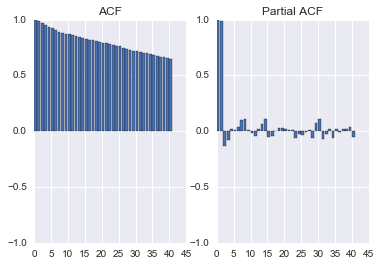

In [5]:
from statsmodels.graphics.tsaplots import acf, pacf

fig, axes = plt.subplots(1, 2)
a = acf(stock_data.VALUE)
axes[0].bar(range(len(a)), a)
axes[0].set_ylim(-1,1)
axes[0].set_title('ACF')

p = pacf(stock_data.VALUE)
axes[1].bar(range(len(p)), p)
axes[1].set_ylim(-1,1)
axes[1].set_title('Partial ACF')

We see strong ACF which indicates noisy data. We know that a model like AR(2) won't work very well but we'll try it anyway. 

This model fits a second order autoregressive model to the incidence time series to check how well current incidence can be predicted from the previous two weeks. That is, we fit the following relationship: ",

$$\theta_t = \mu + \rho_1 y_{t-1} + \rho_2 y_{t-2}$$ 

where the $\rho_1, \rho_2$ parameters are the influence of information one week and two weeks prior, respectively, 
on the current expected incidence ($\theta_t$). 

We then use this value in a normal likelihood to predict the observed value $y_t$: 
$$y_t \sim N(\theta_t, \tau$$

In [8]:
oil_data = stock_data.set_index('DATE')

In [9]:
import pymc3 as pm

y = oil_data.VALUE

with pm.Model() as ar2:
    
    mu = pm.Normal('mu', 0, 1e-6)
    
    # Autoregressive parameters
    ar = 2
    rho = pm.Normal('rho', 0, 1e-3, shape=ar)
    
    sigma = pm.Uniform('sigma', 0, 100)
    tau = sigma ** -2
    
    # Expected values
    theta = pm.Deterministic('theta', mu + rho[0]*y[:-2] + rho[1]*y[1:-1])
    
    incid = pm.Normal('incid', theta, tau, observed=y[ar:])
    incid_pred = pm.Normal('incid_pred', theta, tau, shape=y[ar:].shape)

Applied interval-transform to sigma and added transformed sigma_interval to model.


In [10]:
with ar2:
    
    tr = pm.sample(2000)

Assigned NUTS to mu
Assigned NUTS to rho
Assigned NUTS to sigma_interval
Assigned NUTS to incid_pred
 [-----------------100%-----------------] 2000 of 2000 complete in 6.8 sec

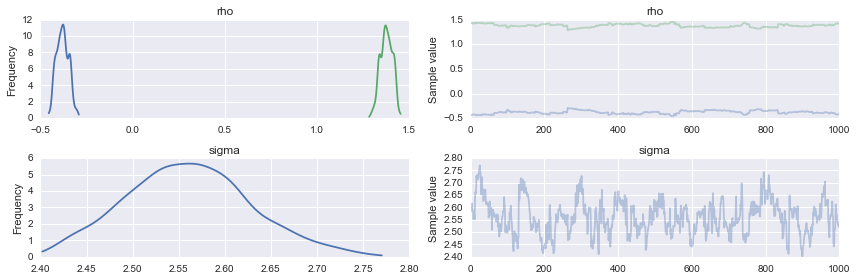

In [12]:

pm.traceplot(tr[1000:], varnames=['rho', 'sigma']);

We can see here that our model isn't very good ready. You'd expect the two rho's to be closer together.
We'll continue because this is an exercise in **bad modelling**. 

Predicted price. 

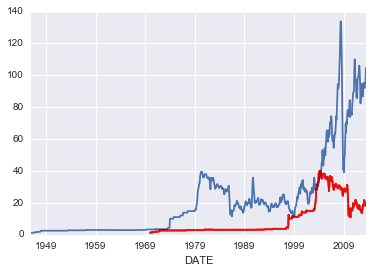

In [13]:
ax = oil_data.VALUE.plot()
ax.plot(tr[-100:]['theta'].T, alpha=0.02, color='r');


Predicted incidence (or price in our case), that is, including sampling variation as well as parametric uncertainty.

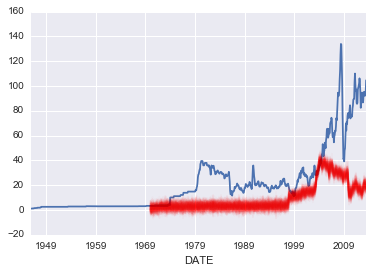

In [14]:
ax = oil_data.VALUE.plot()
ax.plot(tr[-100:]['incid_pred'].T, alpha=0.02, color='r');


You can probably guess the answer...
if predicting the energy market were this easy, everyone would be doing it! 
Obviously the point of this analysis wasn't to claim that you can predict the market with these techniques, 
but rather to demonstrate the types of the analysis one might use when breaking down time series data. Hope you enjoyed it!